#Exercício em Python - Tema 9 - Modelos hidrológicos


Neste exercício, vamos construir um modelo hidrológico conceitual simples baseado no modelo de reservatório linear. Este modelo assume que o escoamento superficial é proporcional ao volume de água armazenado em um "reservatório" fictício, sendo útil para estimar o escoamento de uma bacia hidrográfica. Para isso, foi implementado o modelo conceitual hymod.


## 1. Importar bibliotecas

In [15]:
import pandas as pd
import numpy as np
import pygad
import matplotlib.pyplot as plt
from datetime import datetime
from decimal import Decimal
import io
import requests

### Read files - Google Drive

In [ ]:
#Conexao com o Google Drive. Pode-se conectar com outras plataformas ou usar dados locais
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##%cd /content/drive/Shareddrives/Projeto Exercícios CABra/Exercícios/Exercicios_Mudancas_Climaticas/Dados
#%cd /content/drive/MyDrive/CABra_climate_daily_series/

/content/drive/MyDrive/CABra_climate_daily_series


## Obter a série de dados de precipitação diária

In [2]:
#Escolha da bacia e base de dados (no caso, "ensemble")
bacia1 = "378"
base1 = "ens"
base2 = "ENS"

url = ("https://raw.githubusercontent.com/brunokenmarchezepe/CABra_exercicios/main/CABRA_dataset/CABra_climate_daily_series/" + base1 + "/CABra_" + bacia1 + "_climate_" + base2 + ".txt")

bacia_df = requests.get(url).content
bacia_df = pd.read_csv(io.StringIO(bacia_df.decode('utf-8', errors = 'ignore')),
                 skiprows = 13,
                 delimiter='\t')

bacia_df.columns = ['Year', 'Month', 'Day', 'PREC', 'tmin', 'tmax', 'rh', 'wnd', 'srad', 'et', 'PET PM','pet_pt', 'pet_hg']

#Exclui linha 0 pois não faz parte dos dados
bacia_df = bacia_df.drop([0], axis=0)

In [3]:
precipitacao_dados = bacia_df

# Cria coluna unindo as datas
data = []
# Iterar usando o indice do dataframe using the DataFrame's index to avoid the KeyError
for index in precipitacao_dados.index:
    year = precipitacao_dados.loc[index, 'Year'].strip() # A funcao strip() apaga qualquer espaço em branco existente na celula
    month = precipitacao_dados.loc[index, 'Month'].strip()
    day = precipitacao_dados.loc[index, 'Day'].strip()
    data.append(datetime.strptime(str(year) + "/" + str(month) + "/" + str(day), "%Y/%m/%d").date())

precipitacao_dados['data'] = data

precipitacao_dados

,Year,Month,Day,PREC,tmin,tmax,rh,wnd,srad,et,PET PM,pet_pt,pet_hg,data
1,1980,1,1,5.297,19.269,24.198,89.542,1.912,11.618,2.023,3.000,3.660,2.532,1980-01-01
2,1980,1,2,7.198,18.454,24.801,81.886,1.442,14.943,1.358,3.716,4.543,3.246,1980-01-02
3,1980,1,3,0.631,17.549,26.430,77.475,0.913,19.506,2.782,4.741,5.788,4.275,1980-01-03
4,1980,1,4,0.048,16.880,29.086,70.959,0.959,26.884,4.350,6.506,7.883,6.039,1980-01-04
5,1980,1,5,0.657,18.559,27.499,77.323,2.303,24.326,3.872,5.903,7.188,5.472,1980-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11319,2010,12,27,11.025,19.644,28.139,79.434,1.162,19.248,3.836,4.841,5.853,4.420,2010-12-27
11320,2010,12,28,20.373,19.407,26.211,87.557,1.485,14.444,2.193,3.736,4.468,3.231,2010-12-28
11321,2010,12,29,32.378,19.416,24.915,89.400,1.561,11.542,1.810,3.042,3.656,2.543,2010-12-29
11322,2010,12,30,37.530,19.537,23.926,90.191,1.298,9.084,1.446,2.443,2.982,1.980,2010-12-30


In [4]:
#Colocar o id da bacia hidrográficas do CABra
# id_bacia = 378 #

# #Colocar o caminho (link) dos dados
# caminho = "/content/drive/MyDrive/CABra_climate_daily_series/climate_daily/ens/"+"CABra_"+str(id_bacia)+"_climate_"+"ENS"+".txt"

# #Lendo as informacoes
# precipitacao_dados = pd.read_csv(caminho,
#                                  encoding='latin',
#                                  delimiter='\t',
#                                  skiprows=[0,1,2,3,4,5,6,7,8,9,10,11,12,14]
#                   )


# data = []
# for i in range(len(precipitacao_dados)):
#   data.append(datetime.strptime(str(precipitacao_dados[' Year'][i])+"/"+str(precipitacao_dados[' Month'][i])+"/"+str(precipitacao_dados['   Day'][i]),"%Y/%m/%d").date())

# precipitacao_dados['data'] = data


# precipitacao_dados = precipitacao_dados.rename(columns={'     PREC': 'PREC'})
# precipitacao_dados = precipitacao_dados.rename(columns={' Year': 'Year'})
# precipitacao_dados = precipitacao_dados.rename(columns={' Month': 'Month'})
# precipitacao_dados = precipitacao_dados.rename(columns={'   Day': 'Day'})




In [5]:
#Importação de dados de vazão observados
url = ("https://raw.githubusercontent.com/brunokenmarchezepe/CABra_exercicios/main/CABRA_dataset/CABra_daily_streamflow" + "/CABra_" + bacia1 + "_streamflow.txt")

bacia_df_streamflow = requests.get(url).content
bacia_df_streamflow = pd.read_csv(io.StringIO(bacia_df_streamflow.decode('utf-8', errors = 'ignore')),
                 skiprows = 8,
                 delimiter='\t')

bacia_df_streamflow.columns = ['Year','Month','Day','Streamflow','Quality']
bacia_df_streamflow = bacia_df_streamflow.drop([0], axis=0)

In [6]:
streamflow_dados = bacia_df_streamflow

# Cria coluna unindo as datas
data = []
# Iterar usando o indice do dataframe using the DataFrame's index to avoid the KeyError
for index in streamflow_dados.index:
    year = streamflow_dados.loc[index, 'Year'].strip() # A funcao strip() apaga qualquer espaço em branco existente na celula
    month = streamflow_dados.loc[index, 'Month'].strip()
    day = streamflow_dados.loc[index, 'Day'].strip()
    data.append(datetime.strptime(str(year) + "/" + str(month) + "/" + str(day), "%Y/%m/%d").date())

streamflow_dados['data'] = data

streamflow_dados

,Year,Month,Day,Streamflow,Quality,data
1,1980,10,1,91.842,2,1980-10-01
2,1980,10,2,96.268,2,1980-10-02
3,1980,10,3,91.842,2,1980-10-03
4,1980,10,4,90.392,2,1980-10-04
5,1980,10,5,91.842,2,1980-10-05
...,...,...,...,...,...,...
10953,2010,9,26,NaN,2,2010-09-26
10954,2010,9,27,NaN,2,2010-09-27
10955,2010,9,28,NaN,2,2010-09-28
10956,2010,9,29,NaN,2,2010-09-29


## Modelo hidrológico

In [7]:
def hymod(data, param, area, tdelta, e, p, w_initial=0, wslow_initial=0, wquick_initial=0,warmup=365):
    cmax = param[0]
    beta = param[1]
    alfa = param[2]
    kslow = param[3]
    kquick = param[4]

    area = area * 1e6  # Convert area to m²
    fatconv = 1 / 1000 / tdelta * area
    ntstep = len(p)

    w2 = w_initial
    wslow = wslow_initial
    wquick = [wquick_initial] * 3  # Initialize wquick as a list of three elements

    c1 = 0
    w1 = np.zeros(ntstep)
    er1 = np.zeros(ntstep)
    er2 = np.zeros(ntstep)
    er = np.zeros(ntstep)
    ep = np.zeros(ntstep)
    qslow = np.zeros(ntstep)
    qtquick = np.zeros(ntstep)
    qtslow = np.zeros(ntstep)
    qtot = np.zeros(ntstep)

    # Convert Pandas Series to NumPy arrays to ensure 0-based indexing
    p = p.values
    e = e.values

    for i in range(ntstep):
        w1[i] = w2
        dummy = (1 - ((beta + 1) * w1[i] / cmax))
        dummy = max(dummy, 0)
        c1 = cmax * (1 - (dummy ** (1 / (beta + 1))))

        c2 = min(c1 + p[i], cmax)
        er1[i] = max((p[i] - cmax + c1), 0)
        dummy = 1 - c2 / cmax
        dummy = max(dummy, 0)
        w2 = (cmax / (beta + 1)) * (1 - (dummy ** (beta + 1)))

        er2[i] = max((c2 - c1) - (w2 - w1[i]), 0)
        ep[i] = (1 - (((cmax - c2) / (beta + 1)) / (cmax / (beta + 1)))) * e[i]
        w2 = max(w2 - ep[i], 0)

        uquick = alfa * er2[i] + er1[i]
        uslow = (1 - alfa) * er2[i]
        wslow = (1 - kslow) * wslow + (1 - kslow) * uslow
        qslow[i] = (kslow / (1 - kslow)) * wslow

        qquick = 0
        for j in range(3):
            wquick[j] = (1 - kquick) * wquick[j] + (1 - kquick) * uquick
            qquick = (kquick / (1 - kquick)) * wquick[j]
            uquick = qquick

        qtslow[i] = qslow[i] * fatconv
        qtquick[i] = qquick * fatconv
        qtot[i] = qtquick[i] + qtslow[i]

    return({
        "w_tot": w1[warmup:],
        "ep_tot": ep[warmup:],
        "q_slow": qtslow[warmup:],
        "q_quick": qtquick[warmup:],
        "streamflow": qtot[warmup:],
        "data": data[warmup:]
    })

## Estudo de caso

In [8]:
e = precipitacao_dados['PET PM'].astype(float)
p = precipitacao_dados['PREC'].astype(float)
data = precipitacao_dados['data']
area = 10789.38

param = [847.9494, 0.4592565, 0.379336, 0.007841399, 0.344429]
resultados = hymod(data,
                   param,
                   area,
                   86400,
                   e,
                   p,
                   w_initial=0, wslow_initial=0, wquick_initial=0,warmup=365
                                )

resultados

{'w_tot': array([481.10411873, 490.26026663, 505.41905451, ..., 469.31707652,
        485.87958673, 504.50750629]),
 'ep_tot': array([2.57505534, 2.88023361, 2.30599288, ..., 2.17516881, 1.84386924,
        2.58872823]),
 'q_slow': array([106.78036456, 115.31654255, 121.09884301, ..., 112.44742833,
        121.93299934, 126.95094331]),
 'q_quick': array([143.99866934, 187.20299462, 238.16932262, ..., 187.40882413,
        243.56238579, 299.19017112]),
 'streamflow': array([250.7790339 , 302.51953718, 359.26816563, ..., 299.85625245,
        365.49538513, 426.14111443]),
 'data': 366      1980-12-31
 367      1981-01-01
 368      1981-01-02
 369      1981-01-03
 370      1981-01-04
             ...    
 11319    2010-12-27
 11320    2010-12-28
 11321    2010-12-29
 11322    2010-12-30
 11323    2010-12-31
 Name: data, Length: 10958, dtype: object}

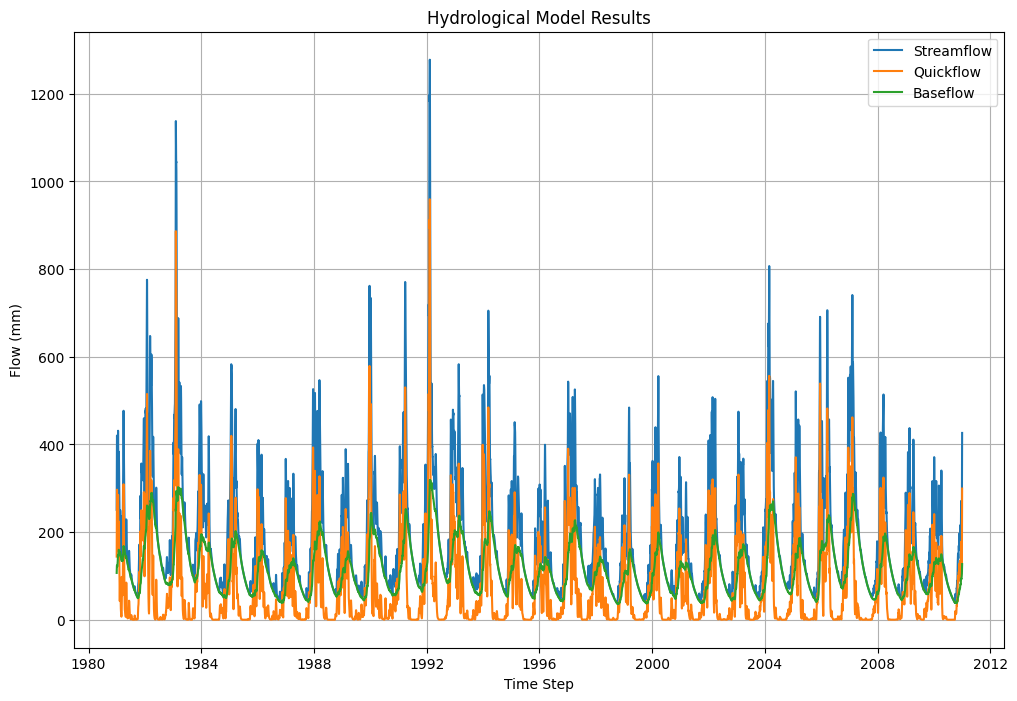

In [12]:
plt.figure(figsize=(12, 8))

plt.plot(resultados['data'],resultados['streamflow'], label='Streamflow')
plt.plot(resultados['data'],resultados['q_quick'], label='Quickflow')
plt.plot(resultados['data'],resultados['q_slow'], label='Baseflow')

plt.xlabel('Time Step')
plt.ylabel('Flow (mm)')
plt.title('Hydrological Model Results')
plt.legend()
plt.grid(True)
plt.show()



### Comparação de dado simulado vs observado

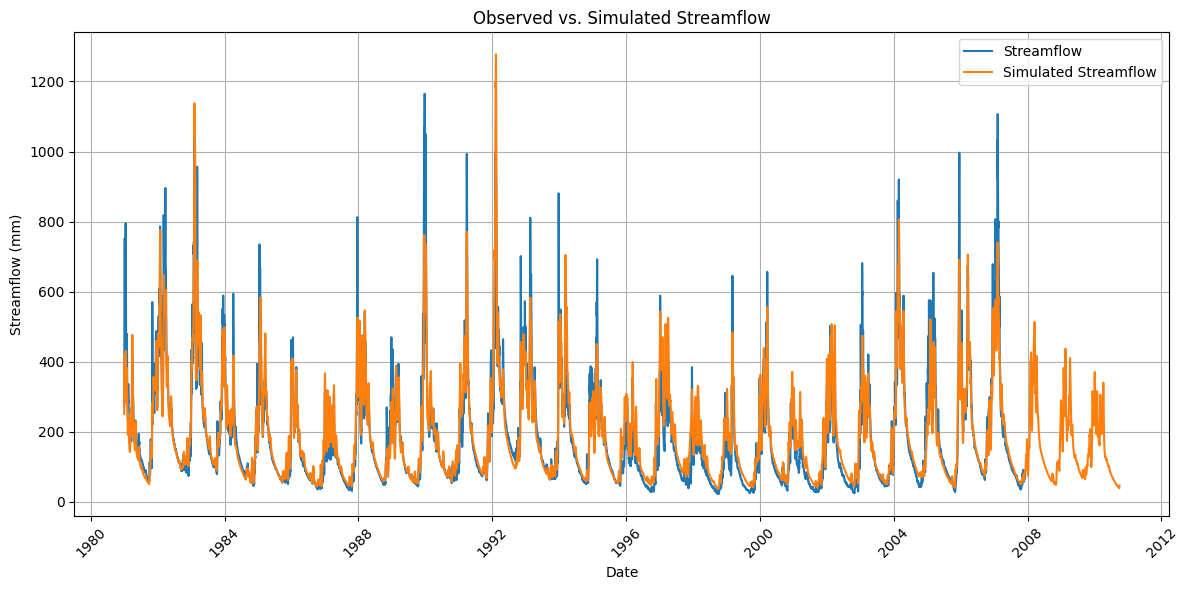

In [9]:
# Convert streamflow to a DataFrame
streamflow_simulated = pd.DataFrame({'data': resultados['data'], 'streamflow_simulated': resultados['streamflow']})

# Merge the DataFrames
merged_df = pd.merge(streamflow_dados, streamflow_simulated, on='data', how='inner')
merged_df['Streamflow'] = merged_df['Streamflow'].astype(float)
# Display the merged DataFrame
merged_df

plt.figure(figsize=(12, 6))
plt.plot(merged_df['data'], merged_df['Streamflow'], label='Streamflow')
plt.plot(merged_df['data'], merged_df['streamflow_simulated'], label='Simulated Streamflow')
plt.xlabel('Date')
plt.ylabel('Streamflow (mm)')
plt.title('Observed vs. Simulated Streamflow')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
import numpy as np

def calculate_performance_metrics(observed, simulated):
    """Calculates performance metrics for hydrological model simulations.

    Args:
        observed: A NumPy array of observed values.
        simulated: A NumPy array of simulated values.

    Returns:
        A dictionary containing the performance metrics.
    """

    # Remove NaN values for calculations
    mask = ~np.isnan(observed) & ~np.isnan(simulated)
    observed = observed[mask]
    simulated = simulated[mask]

    # Calculate metrics
    r2 = np.corrcoef(observed, simulated)[0, 1] ** 2  # R-squared
    nse = 1 - np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2) # Nash-Sutcliffe efficiency
    pbias = 100 * np.sum(simulated - observed) / np.sum(observed) # Percent bias
    rmse = np.sqrt(np.mean((observed - simulated) ** 2))  # Root mean squared error


    return {
        "R-squared": r2,
        "Nash-Sutcliffe Efficiency": nse,
        "Percent Bias": pbias,
        "RMSE": rmse
    }

# Example usage (assuming 'merged_df' is your DataFrame):
observed_streamflow = merged_df['Streamflow'].values
simulated_streamflow = merged_df['streamflow_simulated'].values

metrics = calculate_performance_metrics(observed_streamflow, simulated_streamflow)
metrics

{'R-squared': 0.8890318319939443,
 'Nash-Sutcliffe Efficiency': 0.8848644854325874,
 'Percent Bias': 5.3098459689684265,
 'RMSE': 51.35867094147699}

### Calibração

In [ ]:
def calibrate_model(observed_q,
                    data, e,p,area,
                    initial_guess, bounds=None,
                    num_generations=50, sol_per_pop=20):
    """
    Calibrate model parameters using a genetic algorithm (pygad).

    Parameters
    ----------
    model : object
        Model instance with attributes:
        - param: array of parameters to calibrate
        - run(): returns a dict with key 'streamflow'
    observed_q : array-like
        Observed streamflow values.
    initial_guess : list or array
        Initial parameter guesses.
    bounds : list of tuples, optional
        Parameter bounds as [(low, high), ...].
    num_generations : int, default=50
        Number of generations for GA.
    sol_per_pop : int, default=20
        Number of solutions per population.

    Returns
    -------
    best_solution : array
        Calibrated parameters.
    """

    def nse(simulated_q, observed_q):
        return 1 - np.sum((observed_q - simulated_q) ** 2) / np.sum((observed_q - np.mean(observed_q)) ** 2)

    def objective_function(ga_instance, solution, solution_idx):
        # Assign parameters to the model
        param = solution
        simulated_q = hymod(data,
                   param,
                   area,
                   86400,
                   e,
                   p,
                   w_initial=0, wslow_initial=0, wquick_initial=0,warmup=365)['streamflow']
        return -nse(simulated_q, observed_q[365:])  # PyGAD maximizes by default

    num_params = len(initial_guess)


     # Define search space
    if bounds:
        gene_space = [{'low': low, 'high': high} for low, high in bounds]
    else:
        gene_space = [{'low': ig * 0.5, 'high': ig * 1.5} for ig in initial_guess]

    ga_instance = pygad.GA(
        num_generations=num_generations,
        num_parents_mating=10,
        fitness_func=objective_function,
        sol_per_pop=sol_per_pop,
        num_genes=num_params,
        gene_space=gene_space,
        parent_selection_type="sss",
        crossover_type="single_point",
        mutation_type="random",
        mutation_percent_genes=10,
        stop_criteria=["saturate_10"]
    )

    ga_instance.run()

    # Best solution
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    model.param = solution

    return solution

In [49]:
merged_df = pd.merge(precipitacao_dados, streamflow_dados, on='data', how='inner').dropna()
e = merged_df['PET PM'].astype(float)
p = merged_df['PREC'].astype(float)
observed_q = merged_df['Streamflow'].astype(float)
data = merged_df['data']
area = 10789.38

print(len(observed_q),len(e),len(data),len(p))

10957 10957 10957 10957


In [54]:
calibrate_model(observed_q = observed_q,
                data = data,e = e,p = p, area = area,initial_guess=param)

c:\Users\marco\anaconda3\Lib\site-packages\pygad\pygad.py:753: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
operands could not be broadcast together with shapes (10957,) (10592,) 
Traceback (most recent call last):
  File "c:\Users\marco\anaconda3\Lib\site-packages\pygad\pygad.py", line 1559, in cal_pop_fitness
    fitness = self.fitness_func(self, sol, sol_idx)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\marco\AppData\Local\Temp\ipykernel_10300\399073964.py", line 44, in object

ValueError: operands could not be broadcast together with shapes (10957,) (10592,) 

<ipython-input-32-3e4a0f0b38b8>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


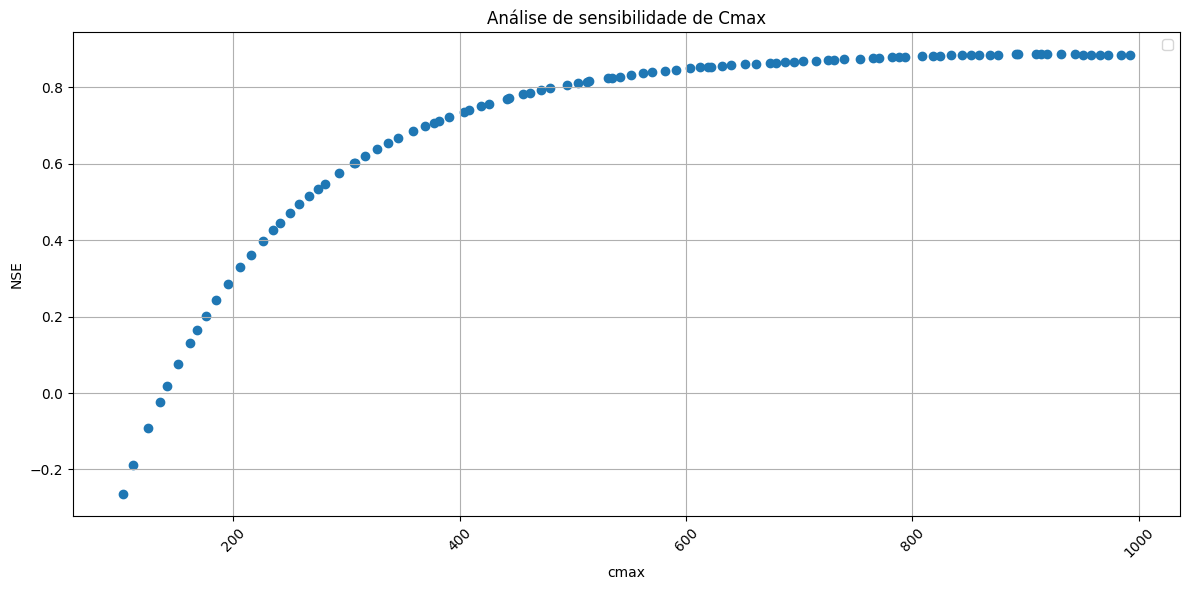

In [32]:
plt.figure(figsize=(12, 6))
plt.scatter(output_df['cmax'], output_df['NSE'])
plt.xlabel('cmax')
plt.ylabel('NSE')
plt.title('Análise de sensibilidade de Cmax')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()